In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/test.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv


In [2]:
import pandas as pd, numpy as np, torch as t
PATH = '/Users/pranjal/Google Drive/Projects/github/kaggle_pytorch/demand_forecasting/demand-forecasting-kernels-only/'
PATH = "../input/demand-forecasting-kernels-only/"
sub_path = PATH + 'sample_submission.csv'
train_path = PATH + 'train.csv'
test_path = PATH + 'test.csv'

sub = pd.read_csv(sub_path)
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

# no null values in all 3 datasets
# 1826 training rows per store item, 90 test rows; for 500 distinct store items.
# train data from 2013 to 2017 full. 
test['store_item'] = test['store'].astype('str') + test['item'].astype('str')
train['store_item'] = train['store'].astype('str') + train['item'].astype('str')

print(sub.shape, train.shape, test.shape)

(45000, 2) (913000, 5) (45000, 5)


In [3]:
def preProcess(train, item, resample='d', rolling = 7):
    temp = train[train['store_item'] == item]
    temp.drop(['store', 'item', 'store_item'], axis = 1, inplace = True)
    temp.date = pd.to_datetime(temp.date)
    temp = temp.set_index('date')
    #temp = temp.resample(resample).mean()
    #temp['sales'] = temp['sales'].rolling(rolling, center=True, min_periods=1).mean()
    temp = temp.values
    return temp

item = '11'
temp = preProcess(train, item, 'd')
print(temp.shape)

(1826, 1)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


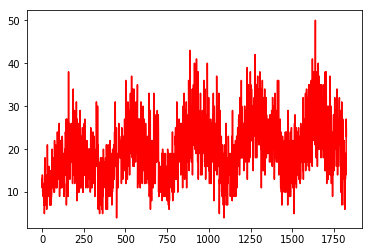

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(temp, color='r')
plt.show()

In [5]:
def Train_Test_Split(S, split = 0.6, scale = True):
    S = t.tensor(temp.reshape(1, -1), dtype=t.float)
    split = round(S.shape[1] * split)
    S_train = S[:, :split]
    S_test = S[:, split:]
    minimum, maximum = S_train.min(), S_train.max()
    if scale == True:
        S_train = (S_train - minimum)/(maximum - minimum)
        return S_train, S_test, minimum, maximum
    else:
        return S_train, S_test, 0, 0

In [6]:
# ANN 
def x_and_y_from_sequence(S, window=12, train = True):
    N = S.shape[1]
    M = abs(N - window)
    x = t.zeros(M, window)
    for i in range(M):
        x[i, :] = t.tensor(S[:, i:i+window])
    if train == True:
        y = t.zeros(M, 1)
        for i in range(M):
            y[i, :] = t.tensor(S[:, i+window])
        return x, y
    else:
        return x
    
def train_model(x_train, y_train, lags, rounds = 1000, lrate = 0.1, decay = 0.01):
    hidden = round(lags / 2)
    model = t.nn.Sequential(
        t.nn.Linear(lags, hidden), 
        t.nn.LeakyReLU(),
        t.nn.Linear(hidden, round(hidden/2)),
        t.nn.LeakyReLU(),
        t.nn.Linear(round(hidden/2), 1)
    )
    model.cuda()
    loss_fn = t.nn.MSELoss()
    optimizer = t.optim.Adam(model.parameters(), lr = lrate, amsgrad = True, weight_decay = decay)
    
    for i in range(rounds):
        yhat = model(x_train.cuda())
        loss = loss_fn(yhat, y_train.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

# N Step Ahead Predictions
def score(S_train, window, steps):
    S_train = S_train.cuda()
    scores = t.zeros( steps, window + 1).cuda()
    scores[0, :-1] = t.tensor(S_train[:, -window:])
    for i in range(steps):
        scores[i, -1] = model(scores[i, :-1])
        if i + 1 < steps:
            scores[i+1, :-1] = scores[i, 1:]
    return scores[:, -1]



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([730])) that is different to the 

tensor(23.9218, grad_fn=<MeanBackward0>)


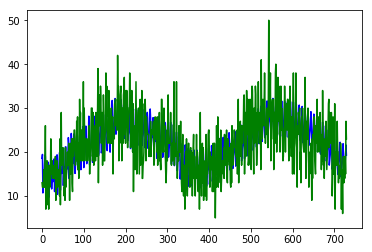

In [7]:
store_items = list(train.store_item.unique())
item = '11'
lags = 365
aggregation = 'd'

total_loss = t.nn.MSELoss()
temp = preProcess(train, item, aggregation)
S = t.tensor(temp, dtype = t.float)
S_train, S_test, minimum, maximum = Train_Test_Split(S, scale = True)
x_train, y_train = x_and_y_from_sequence(S_train, lags)
model = train_model(x_train, y_train, lags, rounds = 1000, lrate = 0.01, decay = 0.01)
steps = S_test.shape[1]
yhat = score(S_train, lags, steps)
del(model)
del(x_train)
del(y_train)
del(S_train)
yhat = yhat.cpu()
yhat = yhat * (maximum - minimum) + minimum
plt.plot(yhat.reshape(-1).detach().numpy(), c = 'b')
plt.plot(S_test[0, :].detach().numpy(), c = 'g')
print(total_loss(S_test, yhat))

tensor(23.9218, grad_fn=<MeanBackward0>)


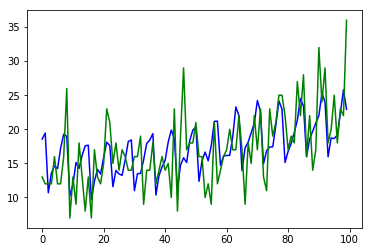

In [8]:
plt.plot(yhat[0:100].reshape(-1).detach().numpy(), c='b')
plt.plot(S_test[0, 0:100].detach().numpy(), c = 'g')
print(total_loss(S_test, yhat))
del(yhat)

In [9]:
store_items = list(train.store_item.unique())
output = pd.DataFrame()
aggregation= 'd'
lags = 365
i = '11'
temp = preProcess(train, i, aggregation)
S = t.tensor(temp)
S_train, S_test, minimum, maximum = Train_Test_Split(S, split = 1, scale = True)
x_train, y_train = x_and_y_from_sequence(S_train, lags)
model = train_model(x_train, y_train, lags, rounds = 1000, lrate = 0.01, decay = 0.01)
for i in store_items:
    print(i)
    total_loss = t.nn.MSELoss()
    S_test = test['id'][test.store_item == i].values
    steps = S_test.shape[0]
    yhat = score(S_train, lags, steps)
    yhat = yhat * (maximum - minimum) + minimum
    pred = pd.DataFrame(np.c_[S_test.reshape(-1, 1), yhat.cpu().detach().numpy().reshape(-1, 1)])
    pred.columns = ['id', 'sales']
    output = pd.concat([output, pred], axis = 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


11
21
31
41
51
61


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


71
81
91
101
12
22
32
42
52
62
72
82
92
102
13
23
33
43
53
63
73
83
93
103
14
24
34
44
54
64
74
84
94
104
15
25
35
45
55
65
75
85
95
105
16
26
36
46
56
66
76
86
96
106
17
27
37
47
57
67
77
87
97
107
18
28
38
48
58
68
78
88
98
108
19
29
39
49
59
69
79
89
99
109
110
210
310
410
510
610
710
810
910
1010
111
211
311
411
511
611
711
811
911
1011
112
212
312
412
512
612
712
812
912
1012
113
213
313
413
513
613
713
813
913
1013
114
214
314
414
514
614
714
814
914
1014
115
215
315
415
515
615
715
815
915
1015
116
216
316
416
516
616
716
816
916
1016
117
217
317
417
517
617
717
817
917
1017
118
218
318
418
518
618
718
818
918
1018
119
219
319
419
519
619
719
819
919
1019
120
220
320
420
520
620
720
820
920
1020
121
221
321
421
521
621
721
821
921
1021
122
222
322
422
522
622
722
822
922
1022
123
223
323
423
523
623
723
823
923
1023
124
224
324
424
524
624
724
824
924
1024
125
225
325
425
525
625
725
825
925
1025
126
226
326
426
526
626
726
826
926
1026
127
227
327
427
527
627
727
827
927
1027
1

In [10]:
output = output.sort_values(by = 'id', ascending = True)
output.id = output.id.astype('int')
output['sales'] = np.round(output['sales']).astype(int)
output.to_csv("submission.csv", index=False)